**Initial step:** Please try to put the extracted heavy_makeup_CelebA folder in your Google Drive!
So now you could mount your data to this ipynb!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# if you mount Google drive correctly, the following commands should be able to be executed correctly
!ls /content/drive/
%cd "/content/drive/My Drive"
%cd "heavy_makeup_CelebA"

!ls

'My Drive'  'Shared drives'
/content/drive/My Drive
/content/drive/My Drive/heavy_makeup_CelebA
train  val


In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
## Please try to adjust data augmentation strategy here
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# the directory of your data in Google Drive
data_dir = '/content/drive/My Drive/heavy_makeup_CelebA'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

Let's show some training data. Make sure the lables match the images

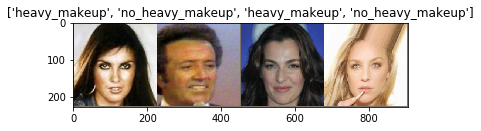

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate
Saving the best model
In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)                            
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Case 1:**
using ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [0]:
model_conv = models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    # param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier = nn.Sequential(*[model_conv.classifier[i] for i in range(6)]) # remove the last layer (4096x1000)
addition_fc = nn.Linear(4096, 2) # the layer to be stacked
model_conv.classifier = nn.Sequential(model_conv.classifier,addition_fc)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

Let's train the model as a feature extractor

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.7868 Acc: 0.7300
val Loss: 1.1212 Acc: 0.7650

Epoch 1/24
----------
train Loss: 1.6537 Acc: 0.7670
val Loss: 1.3986 Acc: 0.8025

Epoch 2/24
----------
train Loss: 1.6395 Acc: 0.7840
val Loss: 1.0739 Acc: 0.7950

Epoch 3/24
----------
train Loss: 1.6099 Acc: 0.7910
val Loss: 2.4007 Acc: 0.7400

Epoch 4/24
----------
train Loss: 1.5873 Acc: 0.7850
val Loss: 1.4935 Acc: 0.7525

Epoch 5/24
----------
train Loss: 0.9366 Acc: 0.8305
val Loss: 0.8451 Acc: 0.8125

Epoch 6/24
----------
train Loss: 0.7597 Acc: 0.8330
val Loss: 0.7598 Acc: 0.8175

Epoch 7/24
----------
train Loss: 0.7317 Acc: 0.8240
val Loss: 0.7927 Acc: 0.8075

Epoch 8/24
----------
train Loss: 0.6288 Acc: 0.8380
val Loss: 0.7135 Acc: 0.8025

Epoch 9/24
----------
train Loss: 0.6614 Acc: 0.8315
val Loss: 0.6648 Acc: 0.8125

Epoch 10/24
----------
train Loss: 0.6105 Acc: 0.8430
val Loss: 0.6862 Acc: 0.8075

Epoch 11/24
----------
train Loss: 0.6332 Acc: 0.8315
val Loss: 0.6708 Acc: 0.8075

Ep

**Case 2**: Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [39]:
## Alexnet
# model_ft = models.alexnet(pretrained=True)
# model_ft = models.alexnet(pretrained=False)

## vgg16
model_ft = models.vgg16(pretrained=True)

# print(model_ft.classifier)
# print(model_ft1.classifier)

model_ft.classifier = nn.Sequential(*[model_ft.classifier[i] for i in range(6)])  # remove the last layer (4096x1000)
addition_fc = nn.Linear(4096, 2) # the layer to be stacked
model_ft.classifier = nn.Sequential(model_ft.classifier,addition_fc)

# model_ft.classifier = nn.Sequential(*[model_ft.classifier])  # remove the last layer (2208x1000)
# addition_fc = nn.Linear(2208, 1) # the layer to be stacked
# model_ft.classifier = nn.Sequential(model_ft.classifier,addition_fc)

#model_ft = nn.Sequential(model_ft,addition_fc)
print(model_ft)
##

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# step size could be
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than 5 minutes.

In [40]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4733 Acc: 0.7870
val Loss: 0.3233 Acc: 0.8575

Epoch 1/24
----------
train Loss: 0.3051 Acc: 0.8720
val Loss: 0.6446 Acc: 0.7350

Epoch 2/24
----------
train Loss: 0.2348 Acc: 0.9055
val Loss: 0.2514 Acc: 0.8950

Epoch 3/24
----------
train Loss: 0.1955 Acc: 0.9190
val Loss: 0.5068 Acc: 0.8200

Epoch 4/24
----------
train Loss: 0.1745 Acc: 0.9315
val Loss: 0.4113 Acc: 0.8550

Epoch 5/24
----------
train Loss: 0.0872 Acc: 0.9660
val Loss: 0.2770 Acc: 0.8900

Epoch 6/24
----------
train Loss: 0.0628 Acc: 0.9750
val Loss: 0.2988 Acc: 0.9000

Epoch 7/24
----------
train Loss: 0.0535 Acc: 0.9830
val Loss: 0.3221 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.0452 Acc: 0.9850
val Loss: 0.3344 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.0333 Acc: 0.9905
val Loss: 0.3630 Acc: 0.9025

Epoch 10/24
----------
train Loss: 0.0242 Acc: 0.9935
val Loss: 0.3702 Acc: 0.9000

Epoch 11/24
----------
train Loss: 0.0226 Acc: 0.9965
val Loss: 0.3756 Acc: 0.9000

Ep

**Visualizing the model predictions:**
Generic function to display predictions for a few images

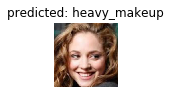

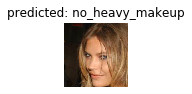

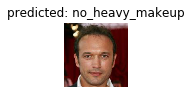

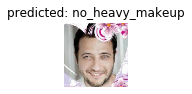

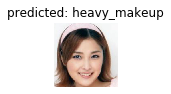

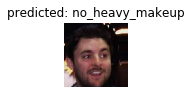

In [41]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
visualize_model(model_ft)